# BoltzRank #
## Luca Negrini - Mat. 956516 ##
### From "BoltzRank: Learning to Maximize Expected Ranking Gain" ###
#### Maxims M. Volkovs, Richard S. Zemel ####

------
#### Initialization ####

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%matplotlib notebook

%load_ext cython

# install lightgbm (required only on first run)
# import sys
# !{sys.executable} -m pip install lightgbm

import os
import os.path
import numpy as np
import lightgbm
import matplotlib.pyplot as plt

# see http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from sklearn.datasets import load_svmlight_file 

# datasets available at: 
# https://www.microsoft.com/en-us/research/project/mslr/
DATASET_FOLDER = "C:/opt/kiis-training/MSLR-WEB10K/Fold0/"
PERM_FOLDER = DATASET_FOLDER + "perms/"
METRIC_NAME = 'ndcg@10'#'BoltzRank-NDCG@10'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The cython extension is already loaded. To reload it, use:
  %reload_ext cython


-----
#### Data loading ####

In [50]:
def ensureFile(path):
    if not os.path.exists(path) or not os.path.isfile(path):
        raise FileNotFoundError("'" + path + "': no such file")        
    return path

def retrieveFileNames():
    folder = DATASET_FOLDER + '/' if DATASET_FOLDER[-1:] != '/' else DATASET_FOLDER
    train_file = ensureFile(folder + "train.txt")
    valid_file = ensureFile(folder + "vali.txt")
    test_file = ensureFile(folder + "test.txt")
    return train_file, valid_file, test_file

def loadDataset(path):
    return load_svmlight_file(path, query_id=True)

def loadLightGBM(svmlight_dataset):
    query_lens = [sum(1 for _ in group) for key, group in itertools.groupby(svmlight_dataset[2])]
    return lightgbm.Dataset(data=svmlight_dataset[0], label=svmlight_dataset[1], group=query_lens)

In [51]:
class Query:
    def __init__(self, qid):
        self.qid = qid
        self.labels_to_docs = {}
    def addlabel(self, label):
        if not label in self.labels_to_docs:
            self.labels_to_docs[label] = list()
    def adddoc(self, label, doc):
        self.labels_to_docs[label].append(doc)
    def finalize(self, alllabels):
        self.labels = np.zeros(len(self.labels_to_docs.keys()), dtype=int)
        self.docs = np.empty(len(self.labels_to_docs.keys()), dtype=object)
        i = 0
        totaldocs = 0
        sorteddict = sorted(self.labels_to_docs.items(), reverse = True)
        for label, docs in sorteddict:
            self.labels[i] = label
            self.docs[i] = np.zeros(len(docs), dtype=int)
            for j in range(len(docs)):
                self.docs[i][j] = docs[j]
            i += 1
            totaldocs += len(docs)
        self.alldocs = np.concatenate(self.docs)
        self.flatlabels = np.zeros(totaldocs, dtype=np.double)
        i = 0
        for label, docs in sorteddict:
            for j in range(len(docs)):
                self.flatlabels[i] = label
                i += 1       
        k = min(10, len(self.alldocs))
        self.idealdcg = dcg_k(self.alldocs, alllabels, k) 
        del self.labels_to_docs
    def setperms(self, perms):
        self.perms = perms
    def setprobs(self, probs):
        self.probs = probs
    def setndcgs(self, ndcgs):
        self.ndcgs = ndcgs
    def __repr__(self):  
        return str(self)
    def __str__(self):
        res = "Query " + str(self.qid) + "["
        res += "\nideal dcg: " + str(self.idealdcg)
        for i in range(len(self.labels)):
            res += "\n" + str(self.labels[i]) + " -> " + str(self.docs[i])
        res += "]"
        if hasattr(self, 'perms'):
            for i in range(len(self.perms)):
                res += "\n[" + str(self.perms[i]) + "] -> p: " + str(self.probs[i]) + ", dcg: " + str(self.ndcgs[i])
        else:
            res += "\nNo permutations computed yet"
        return res

In [52]:
# parameters:
#  dataset: svmlight_dataset 
#      the datset to process
# returned values:
#  query_to_labels_to_documents: dict(int -> dict(float -> list(int)))
#      a map containing, for each query in the dataset, the documents (row index in the dataset) provided 
#      in the input dataset grouped by label
#  doc_to_query: dict(document -> query)
#      a mapping between document (row index in the dataset) and the relative query
def mapQueryToDocuments(dataset):
    queries = {}
    alllabels = np.negative(np.ones(len(dataset[2]), dtype=np.double))
    for i in range(0, len(dataset[2])):
        if not dataset[2][i] in queries:
            queries[dataset[2][i]] = Query(dataset[2][i])
        query = queries[dataset[2][i]]
        query.addlabel(dataset[1][i])
        query.adddoc(dataset[1][i], i)
        alllabels[i] = dataset[1][i]
        
    for q in queries.values():
        q.finalize(alllabels)
    
    return queries, alllabels

-----
#### BoltzRank logic in Cython ####

In [53]:
%%cython 
from libc.math cimport exp
from cython.parallel import prange
from cython import boundscheck, wraparound
from libc.math cimport log, log2
from math import factorial
import numpy as np
import random
import itertools
from libc.stdio cimport printf

###############################################################################################################
###############################################################################################################
#                                              NDCG EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cpdef double dcg_k(int[:] rank, double[:] scores, int k) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(k, schedule='static', num_threads=8):
        result += (2**scores[rank[i]] - 1) / (log2(i + 2)) # should be i+1, but with numbering starting from 1 instead of 0
    return result


@boundscheck(False)
@wraparound(False)
cdef double ndcg_k(int[:] rank, double[:] scores, int k, double ideal) nogil:
    if ideal == 0:
        return 1.0
    return dcg_k(rank, scores, k) / ideal

###############################################################################################################
###############################################################################################################
#                                          PERMUTATIONS GENERATION
###############################################################################################################
###############################################################################################################

RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS = 100
RANK_SAMPLE_SET_DISTRIBUTIONS = [
                                int(.30 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->0
                                int(.22 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->1
                                int(.18 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->2
                                int(.12 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 4->3
                                int(.10 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->0
                                int(.06 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->1
                                int(.02 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 3->2
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->0
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS), # 2->1
                                int(.0 * RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS)  # 1->0
                                ]

@boundscheck(False)
@wraparound(False)
cdef bint contained(int[:,:] container, int[:] array) nogil:
    cdef bint match
    cdef int i
    cdef int j
    for i in prange(len(container), schedule='static', num_threads=8):
        if container[i][0] == -1 or len(container[i]) != len(array):
            continue
        else:
            match = True
            for j in range(len(container[i])):
                if container[i][j] != array[j]:
                    match = False
                    break
            if match:
                return True
    return False

@boundscheck(False)
@wraparound(False)
cdef void setrow(int[:,:] container, int pos, int[:] array) nogil:
    cdef int i
    for i in prange(len(container[pos]), schedule='static', num_threads=8):
        container[pos][i] = array[i]

@boundscheck(False)
@wraparound(False)
cdef int[:,:] allPerms(int[:] source, long long fact):
    cdef int i = 0
    cdef int k
    perm = itertools.permutations(source)
    cdef int[:,:] result = np.zeros((fact, len(source)), dtype=int)
    for p in perm:
        for k in range(len(p)):
            result[i][k] = p[k]
        i += 1
    return result

#source: label -> docid*, i: int, j: int, count: int, perms_with_prob: tuple<int> -> float
#return: number of not computed permutations
@boundscheck(False)
@wraparound(False)
def perform_permutation(query, int i, int j, int count, int[:,:] perms, int start):
    if not i in query.labels or not j in query.labels:
        # no swapping possible
        return count, start
    # find the indexes of the desired labels
    i = [k for k in range(len(query.labels)) if query.labels[k] == i][0]
    j = [k for k in range(len(query.labels)) if query.labels[k] == j][0]
    cdef int c = 0
    cdef int _min = min(len(query.docs[i]), len(query.docs[j]))
    cdef int amount = max(1, int(_min * .5))
    limit = factorial(_min) / (factorial(amount) * factorial(_min - amount))
    cdef int k
    cdef int d
    for k in range(count):
        perm = query.docs.copy()
        first = random.sample(range(len(query.docs[i])), k=amount)
        second = random.sample(range(len(query.docs[j])), k=amount)
        for d in range(len(first)):
            perm[i][first[d]], perm[j][second[d]] = query.docs[j][second[d]], query.docs[i][first[d]]
        p = np.concatenate(perm)
        if not contained(perms, p):
            setrow(perms, start + c, p)
            c += 1
            if c == limit:
                return count - c, start + c
        else:
            k -= 1
    return 0, start + c

@boundscheck(False)
@wraparound(False)
def process_query(query, alllabels):
    cdef int carry = 0
    fact = factorial(len(query.alldocs))
    cdef perms
    cdef int last = 0
    if fact <= RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS:
        # evaluate all possible permutations, each one representing a different ranking
        perms = allPerms(query.alldocs, fact)
    else:
        perms = np.negative(np.ones((RANK_SAMPLE_SET_MAX_QUERY_PERMUTATIONS, len(query.alldocs)), dtype=int))
        # switch the labels of the documents, then sort the documents by label to obtain a ranking
        carry, last = perform_permutation(query, 4, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[0], perms, last)
        carry, last = perform_permutation(query, 4, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[1] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[2] + carry, perms, last)
        carry, last = perform_permutation(query, 4, 3, RANK_SAMPLE_SET_DISTRIBUTIONS[3] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[4] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[5] + carry, perms, last)
        carry, last = perform_permutation(query, 3, 2, RANK_SAMPLE_SET_DISTRIBUTIONS[6] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[7] + carry, perms, last)
        carry, last = perform_permutation(query, 2, 1, RANK_SAMPLE_SET_DISTRIBUTIONS[8] + carry, perms, last)
        carry, last = perform_permutation(query, 1, 0, RANK_SAMPLE_SET_DISTRIBUTIONS[9] + carry, perms, last)
        if carry != 0:
            if not query.alldocs in perms:
                perms[last] = query.alldocs
        perms = perms[perms.max(axis=1)>=0]
    cdef double[:] probs = np.zeros(len(perms))
    cdef double[:] ndcgs = np.zeros(len(perms))
    query.setperms(perms)
    query.setprobs(rank_probabilities(perms, probs, alllabels))
    cdef int k = min(10, len(perms[0]))
    for i in range(len(perms)):
        ndcgs[i] = ndcg_k(perms[i], alllabels, k, query.idealdcg)
    query.setndcgs(ndcgs)
    return query

###############################################################################################################
###############################################################################################################
#                                           GRADIENTS EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cdef double[:,:] doc_energy(int[:] rank, double[:] scores, double[:,:] result) nogil:
    cdef int m = len(rank)
    if m == 1 or m == 0:
        return result
    cdef double factor = 4.0 / (m * ((m - 1)**2))
    cdef double res
    cdef double res_w_scores
    cdef int k, pos
    for pos in prange(len(rank), schedule='static', num_threads=8):
        res = 0.0
        res_w_scores = 0.0
        for k in range(len(rank)):
            if k < pos: 
                res = res + (pos - k)
                res_w_scores = res_w_scores + (pos - k) * (scores[rank[pos]] - scores[rank[k]])
            #elif k > pos: 
            #    res = res + (k - pos)
            #    res_w_scores = res_w_scores + (k - pos) * (scores[rank[k]] - scores[rank[pos]])
        result[rank[pos]][0] = factor * res_w_scores
        result[rank[pos]][1] = factor * res
        #printf("result of %i: m %i, factor %f, res %f, res_scores %f, result[0] %f, result[1] %f\n", pos, m, factor, res_w_scores, res, result[rank[pos]][0], result[rank[pos]][0])
    return result

@boundscheck(False)
@wraparound(False)
cpdef double[:,:,:] doc_rank_probabilities(int[:,:] sampleSet, double[:,:,:] norm_probs, double[:] scores, double[:,:] accumulator, double[:,:] tmp) nogil:
    cdef double norm = 0
    cdef double grad_norm = 0
    cdef double _energy = 0
    cdef double grad_energy = 0
    cdef int r
    cdef int d
    cdef int pos
    cdef int doc
    
    for r in prange(len(sampleSet), schedule='static', num_threads=8):
        doc_energy(sampleSet[r], scores, tmp)
        for d in range(len(sampleSet[r])):
            doc = sampleSet[r][d]
            norm_probs[doc][r][0] = exp(-tmp[doc][0]) # e^{-E}
            norm_probs[doc][r][1] = -tmp[doc][1] * norm_probs[doc][r][0] # -E' * e^{-E}
            accumulator[doc][0] = accumulator[doc][0] + norm_probs[doc][r][0] # sum(e^{-E})
            accumulator[doc][1] = accumulator[doc][1] + norm_probs[doc][r][1] # sum(-E' * e^{-E})
        
        #_energy, grad_energy = doc_energy(sampleSet[r], scores, pos) # E, E'
        #norm_probs[r][0] = exp(-_energy) # e^{-E}
        #norm_probs[r][1] = -grad_energy * norm_probs[r][0] # -E' * e^{-E}
        #norm += norm_probs[r][0] # sum(e^{-E})
        #grad_norm += norm_probs[r][1] # sum(-E' * e^{-E})

    for pos in prange(len(sampleSet[0]), schedule='static', num_threads=8):
        doc = sampleSet[0][pos]
        # -E' * e^{-E} * sum(e^{-E}) - e^{-E} * sum(-E' * e^{-E})
        # _______________________________________________________
        # (sum(e^{-E}))^2
        norm_probs[doc][r][1] = ((norm_probs[doc][r][1] * accumulator[doc][0]) - (norm_probs[doc][r][0] * accumulator[doc][1])) / (accumulator[doc][0]**2)
        norm_probs[doc][r][0] = norm_probs[doc][r][0] / accumulator[doc][0] # e^{-E} / sum(e^{-E})
        
    #for r in prange(len(norm_probs), schedule='static', num_threads=8):
    #    norm_probs[r][0] = norm_probs[r][0] / norm # e^{-E} / sum(e^{-E})
        # -E' * e^{-E} * sum(e^{-E}) - e^{-E} * sum(-E' * e^{-E})
        # _______________________________________________________
        # (sum(e^{-E}))^2
    #    norm_probs[r][1] = ((norm_probs[r][1] * norm) - (norm_probs[r][0] * grad_norm)) / (norm**2) 
    return norm_probs

@boundscheck(False)
@wraparound(False)
cdef double[:,:] grad_cross_entropy(int[:,:] perms, double[:] probs, double[:,:,:] scores_probs, double[:,:] entropies) nogil:
    cdef int i, doc, j
    for i in prange(len(perms[0]), schedule='static', num_threads=8):
        doc = perms[0][i]
        for j in range(len(perms)):
            entropies[doc][0] = entropies[doc][0] + -probs[j] * log(scores_probs[doc][j][0])
            entropies[doc][1] = entropies[doc][1] + -1 * (probs[j] / scores_probs[doc][j][0]) * scores_probs[doc][j][1]
    return entropies

@boundscheck(False)
@wraparound(False)
cdef double[:,:] grad_monte_carlo_gain(int[:,:] perms, double[:,:,:] scores_probs, double[:] scores, double[:] ndcgs, double ideal, double[:,:] gains) nogil:
    cdef int i, doc, j
    cdef int k = min(10, len(perms[0]))
    for i in prange(len(perms[0]), schedule='static', num_threads=8):
        doc = perms[0][i]
        for j in range(len(perms)):
            gains[doc][0] = gains[doc][0] + scores_probs[doc][j][0] * ndcgs[j]#ndcg_k(perms[j], scores, k, ideal)#ndcgs[j]
            gains[doc][1] = gains[doc][1] + scores_probs[doc][j][1] * ndcgs[j]#ndcg_k(perms[j], scores, k, ideal)#ndcgs[j]
    return gains 

@boundscheck(False)
@wraparound(False)
def eval_boltzrank_grads(queries, preds): 
    cdef double lam = .9
    cdef double[:] gain = np.ones_like(preds)
    cdef double[:] hess = np.ones_like(preds) 
    
    cdef int d, i
    cdef double[:,:,:] score_probs
    cdef double[:,:] accumulator = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] tmp = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] gains = np.zeros((len(preds), 2), dtype=np.double) 
    cdef double[:,:] entropies = np.zeros((len(preds), 2), dtype=np.double) 
    for q in queries.values():
        score_probs = np.zeros((len(preds), len(q.probs), 2), dtype=np.double)
        score_probs = doc_rank_probabilities(q.perms, score_probs, preds, accumulator, tmp)
        gains = grad_monte_carlo_gain(q.perms, score_probs, preds, q.ndcgs, q.idealdcg, gains) 
        entropies = grad_cross_entropy(q.perms, q.probs, score_probs, entropies)
    for i in range(len(gain)):
        gain[i] = (lam * gains[i][1]) - ((1-lam) * entropies[i][1])
    return gain, hess

###############################################################################################################
###############################################################################################################
#                                            METRIC EVALUATION
###############################################################################################################
###############################################################################################################

@boundscheck(False)
@wraparound(False)
cdef double energy(int[:] rank, double[:] scores) nogil:
    cdef int m = len(rank)
    if m == 1 or m == 0:
        return 0
    cdef double factor = 4 / (m * ((m - 1)**2))
    cdef double res = 0
    cdef int j, k
    for k in prange(m, schedule='static', num_threads=8):
        for j in range(k + 1, m):
            res += (j - k) * (scores[rank[j]] - scores[rank[k]])
    return factor * res

@boundscheck(False)
@wraparound(False)
cpdef double[:] rank_probabilities(int[:,:] sampleSet, double[:] norm_probs, double[:] scores) nogil:
    cdef double norm = 0
    cdef int r
    for r in prange(len(sampleSet), schedule='static', num_threads=8):
        norm_probs[r] = exp(-energy(sampleSet[r], scores))
        printf("%i %f\n", r, norm_probs[r])
        norm += norm_probs[r]
    printf("%f\n", norm)
    for r in prange(len(norm_probs), schedule='static', num_threads=8):
        norm_probs[r] = norm_probs[r] / norm
    return norm_probs

@boundscheck(False)
@wraparound(False)
cdef double cross_entropy(double[:] probs, double[:] scores_probs) nogil:
    cdef double result = 0
    cdef int i
    for i in prange(len(probs), schedule='static', num_threads=8):
        result += probs[i] * log(scores_probs[i])
    return -result

@boundscheck(False)
@wraparound(False)
cdef double monte_carlo_gain(int[:,:] perms, double[:] scores_probs, double[:] ndcgs) nogil:
    cdef double result = 0
    cdef int i
    cdef int k = min(10, len(perms[0]))
    for i in prange(len(perms), schedule='static', num_threads=8):
        result += scores_probs[i] * ndcgs[i]
    return result

@boundscheck(False)
@wraparound(False)
def eval_boltzrank(queries, preds):
    cdef double lam = .9
    cdef double[:] score_probs
    cdef double mc = 0
    cdef double ce = 0
    cdef double _mc, _ce
    for q in queries.values():
        score_probs = np.zeros(len(q.probs), dtype=np.double)
        score_probs = rank_probabilities(q.perms, score_probs, preds)
        mc += monte_carlo_gain(q.perms, score_probs, q.ndcgs) 
        ce += cross_entropy(q.probs, score_probs)
    return (lam * mc) - ((1-lam) * ce)

In [54]:
train_file, valid_file, test_file = retrieveFileNames()

print("training file: " + train_file)
print("validation file: " + valid_file)
print("test file: " + test_file)
    
print("loading datasets... ")
import time
start = time.process_time()
train_dataset = loadDataset(train_file)
print("train dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
valid_dataset = loadDataset(valid_file)
print("validation dataset loading took " + str(time.process_time() - start) + " s")
start = time.process_time()
test_dataset = loadDataset(test_file)
print("test dataset loading took " + str(time.process_time() - start) + " s")

import itertools
print("converting datasets to LightGBM format... ")
train_lgb = loadLightGBM(train_dataset)
valid_lgb = loadLightGBM(valid_dataset)
test_lgb = loadLightGBM(test_dataset)

print("done")

training file: C:/opt/kiis-training/MSLR-WEB10K/Fold0/train.txt
validation file: C:/opt/kiis-training/MSLR-WEB10K/Fold0/vali.txt
test file: C:/opt/kiis-training/MSLR-WEB10K/Fold0/test.txt
loading datasets... 
train dataset loading took 0.0 s
validation dataset loading took 0.015625 s
test dataset loading took 0.015625 s
converting datasets to LightGBM format... 
done


In [55]:
def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

print("creating query-documents mappings...")
train_id = file_len(train_file)
vali_id = file_len(valid_file)
test_id = file_len(test_file)
ds_to_queries = {}
ds_to_queries[train_id] = mapQueryToDocuments(train_dataset)
ds_to_queries[vali_id] = mapQueryToDocuments(valid_dataset)
ds_to_queries[test_id] = mapQueryToDocuments(test_dataset)
#queries, alllabels = mapQueryToDocuments(train_dataset)
print("done")

print("creating sample sets...")
start = time.process_time()
for ds_id, queries in ds_to_queries.items():
    for q in queries[0].values():
        process_query(q, queries[1])
#for q in queries.values():
#    queries[q.qid] = process_query(q, alllabels)
print("sample set creation took " + str(time.process_time() - start) + " s")
print("done")

creating query-documents mappings...
done
creating sample sets...
sample set creation took 0.015625 s
done


training lightgbm...
preds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
111preds [0.00738128 0.03416078 0.05517349 0.05517349 0.00738128 0.03416078
 0.00738128 0.03416078 0.00738128 0.04081458 0.03838678 0.03416078
 0.03416078 0.05517349 0.03838678 0.06262059 0.06262059 0.01697298
 0.01697298 0.00738128 0.01697298 0.03838678 0.03838678 0.04081458
 0.06262059 0.05517349 0.04236345 0.01697298 0.01697298 0.03416078
 0.03416078 0.04081458 0.06262059 0.05134254 0.05134254 0.01697298
 0.04081458 0.04236345 0.06262059 0.05517349 0.04081458 0.05134254
 0.06262059 0.03838678 0.05517349 0.01697298 0.03838678 0.04081458
 0.06262059 0.05134254 0.03838678 0.04236345 0.04236345 0.04081458
 0.04236345 0.05517349 0.05134254 0.04081458 0.03416078]
111preds [0.06262059 0.05134254 0.04081458 0.00738128 0.05134254 0.05134254
 0.01697298 0.04081458 0.01697298 0.00738128 0.

 0.12707372 0.16543565 0.15397938 0.1224292  0.1024847 ]
111preds [0.18771468 0.15397938 0.1224292  0.02214571 0.15397938 0.15397938
 0.05092595 0.1224292  0.05092595 0.02214571 0.05092595 0.1224292
 0.18771468 0.18771468 0.11515335 0.02214571 0.05092595 0.18771468
 0.15397938 0.18771468 0.15397938 0.11515335 0.1224292  0.1224292
 0.15397938 0.02214571 0.15397938 0.1224292  0.05092595 0.02214571
 0.05092595 0.02214571 0.11515335 0.02214571 0.18771468 0.18771468
 0.18771468 0.15397938 0.1224292  0.05092595 0.05092595 0.1024847
 0.1024847  0.18771468 0.18771468 0.11515335 0.05092595 0.02214571
 0.05092595 0.1224292  0.18771468 0.11515335 0.05092595 0.18771468
 0.05092595 0.11515335 0.1224292  0.02214571 0.15397938 0.11515335
 0.1224292  0.15397938 0.18771468 0.1224292  0.18771468 0.15397938
 0.02214571 0.05092595 0.02214571 0.18771468 0.18771468 0.18771468
 0.1024847  0.18771468 0.05092595 0.18771468 0.02214571 0.18771468
 0.11515335 0.15397938 0.18771468 0.1224292  0.1224292  0.1224292


 0.30143399 0.03691263]
[5]	train's ndcg@10: -0.123715	valid's ndcg@10: -0.173095	test's ndcg@10: -0.05381
preds [0.03691263 0.17081174 0.27558499 0.27558499 0.03691263 0.17081174
 0.03691263 0.17081174 0.03691263 0.20402439 0.19191058 0.17081174
 0.17081174 0.27558499 0.19191058 0.3126134  0.3126134  0.08488822
 0.08488822 0.03691263 0.08488822 0.19191058 0.19191058 0.20402439
 0.3126134  0.27558499 0.2117618  0.08488822 0.08488822 0.17081174
 0.17081174 0.20402439 0.3126134  0.25655197 0.25655197 0.08488822
 0.20402439 0.2117618  0.3126134  0.27558499 0.20402439 0.25655197
 0.3126134  0.19191058 0.27558499 0.08488822 0.19191058 0.20402439
 0.3126134  0.25655197 0.19191058 0.2117618  0.2117618  0.20402439
 0.2117618  0.27558499 0.25655197 0.20402439 0.17081174]
111preds [0.04429703 0.20497641 0.33061746 0.33061746 0.04429703 0.20497641
 0.04429703 0.20497641 0.04429703 0.2448147  0.23028569 0.20497641
 0.20497641 0.33061746 0.23028569 0.37498978 0.37498978 0.10187285
 0.10187285 0.044

 0.48841772 0.48841772 0.48841772]
111preds [0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.30702886
 0.05906768 0.05906768 0.05906768 0.05906768 0.30702886 0.05906768
 0.30702886 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.30702886 0.30702886
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.48841772 0.30702886
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.48841772 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.30702886 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768 0.05906768
 0.05906768 0.0590

 0.46569275 0.6053595  0.56388527 0.44869323 0.37581095]
111preds [0.68614624 0.56388527 0.44869323 0.08122832 0.56388527 0.56388527
 0.18683082 0.44869323 0.18683082 0.08122832 0.18683082 0.44869323
 0.67496684 0.68614624 0.42212593 0.08122832 0.18683082 0.67496684
 0.56388527 0.68614624 0.56388527 0.42212593 0.44869323 0.44869323
 0.56388527 0.08122832 0.56388527 0.44869323 0.18683082 0.08122832
 0.18683082 0.08122832 0.42212593 0.08122832 0.68614624 0.67496684
 0.68614624 0.56388527 0.44869323 0.18683082 0.18683082 0.37581095
 0.37581095 0.67496684 0.67496684 0.42212593 0.18683082 0.08122832
 0.18683082 0.44869323 0.67496684 0.42212593 0.18683082 0.67496684
 0.18683082 0.42212593 0.44869323 0.08122832 0.56388527 0.42212593
 0.44869323 0.56388527 0.67496684 0.44869323 0.67496684 0.56388527
 0.08122832 0.18683082 0.08122832 0.67496684 0.67496684 0.67496684
 0.37581095 0.67496684 0.18683082 0.68614624 0.08122832 0.68614624
 0.42212593 0.56388527 0.68614624 0.44869323 0.44869323 0.44869

 0.78820414 0.78820414 0.78820414]
111preds [0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.49884549
 0.09600518 0.09600518 0.09600518 0.09600518 0.49884549 0.09600518
 0.49884549 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.49884549 0.49884549
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.78820414 0.49884549
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.78820414 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.49884549 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518 0.09600518
 0.09600518 0.0960

 0.91213924 0.11078452]
[15]	train's ndcg@10: -0.124551	valid's ndcg@10: -0.172798	test's ndcg@10: -0.0543755
preds [0.11078452 0.5124916  0.82465128 0.82465128 0.11078452 0.5124916
 0.11078452 0.5124916  0.11078452 0.6117083  0.57555553 0.5124916
 0.5124916  0.82465128 0.57555553 0.93420744 0.93420744 0.25483894
 0.25483894 0.11078452 0.25483894 0.57555553 0.57555553 0.6117083
 0.93420744 0.82465128 0.63486885 0.25483894 0.25483894 0.5124916
 0.5124916  0.6117083  0.93420744 0.76845475 0.76845475 0.25483894
 0.6117083  0.63486885 0.93420744 0.82465128 0.6117083  0.76845475
 0.93420744 0.57555553 0.82465128 0.25483894 0.57555553 0.6117083
 0.93420744 0.76845475 0.57555553 0.63486885 0.63486885 0.6117083
 0.63486885 0.82465128 0.76845475 0.6117083  0.5124916 ]
111preds [0.11817512 0.54666352 0.87940487 0.87940487 0.11817512 0.54666352
 0.11817512 0.54666352 0.11817512 0.65244986 0.61390698 0.54666352
 0.54666352 0.87940487 0.61390698 0.99610364 0.99610364 0.27184676
 0.27184676 0.118175

111preds [0.13295818 0.61500939 0.98882911 0.98882911 0.13295818 0.61500939
 0.13295818 0.61500939 0.13295818 0.7339183  0.69060271 0.61500939
 0.61500939 0.98882911 0.69060271 1.11975387 1.11975387 0.30586932
 0.30586932 0.13295818 0.30586932 0.69060271 0.69060271 0.7339183
 1.11975387 0.98882911 0.76169248 0.30586932 0.30586932 0.61500939
 0.61500939 0.7339183  1.11975387 0.92171475 0.92171475 0.30586932
 0.7339183  0.76169248 1.11975387 0.98882911 0.7339183  0.92171475
 1.11975387 0.69060271 0.98882911 0.30586932 0.69060271 0.7339183
 1.11975387 0.92171475 0.69060271 0.76169248 0.76169248 0.7339183
 0.76169248 0.98882911 0.92171475 0.7339183  0.61500939]
111preds [1.11975387 0.92171475 0.7339183  0.13295818 0.92171475 0.92171475
 0.30586932 0.7339183  0.30586932 0.13295818 0.30586932 0.7339183
 1.07616136 1.11975387 0.69060271 0.13295818 0.30586932 1.07616136
 0.92171475 1.11975387 0.92171475 0.69060271 0.7339183  0.7339183
 0.92171475 0.13295818 0.92171475 0.7339183  0.30586932 0.1

 1.18895465 1.18895465 1.18895465]
111preds [0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.76728886
 0.14774371 0.14774371 0.14774371 0.14774371 0.76728886 0.14774371
 0.76728886 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.76728886 0.76728886
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 1.18895465 0.76728886
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 1.18895465 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.76728886 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371 0.14774371
 0.14774371 0.1477

 0.93071263 1.207347   1.12583926 0.89679644 0.75170913]
111preds [0.16992665 0.78588569 1.26190784 1.26190784 0.16992665 0.78588569
 0.16992665 0.78588569 0.16992665 0.93750371 0.88230003 0.78588569
 0.78588569 1.26190784 0.88230003 1.42805507 1.42805507 0.39096613
 0.39096613 0.16992665 0.39096613 0.88230003 0.88230003 0.93750371
 1.42805507 1.26190784 0.97295373 0.39096613 0.39096613 0.78588569
 0.78588569 0.93750371 1.42805507 1.1768308  1.1768308  0.39096613
 0.93750371 0.97295373 1.42805507 1.26190784 0.93750371 1.1768308
 1.42805507 0.88230003 1.26190784 0.39096613 0.88230003 0.93750371
 1.42805507 1.1768308  0.88230003 0.97295373 0.97295373 0.93750371
 0.97295373 1.26190784 1.1768308  0.93750371 0.78588569]
111preds [1.42805507 1.1768308  0.93750371 0.16992665 1.1768308  1.1768308
 0.39096613 0.93750371 0.39096613 0.16992665 0.39096613 0.93750371
 1.36321956 1.42805507 0.88230003 0.16992665 0.39096613 1.36321956
 1.1768308  1.42805507 1.1768308  0.88230003 0.93750371 0.93750371

 1.65115492 0.20691057]
[28]	train's ndcg@10: -0.125641	valid's ndcg@10: -0.172427	test's ndcg@10: -0.0550946
preds [0.20691057 0.9567779  1.53430224 1.53430224 0.20691057 0.9567779
 0.20691057 0.9567779  0.20691057 1.14096645 1.07393693 0.9567779
 0.9567779  1.53430224 1.07393693 1.73692716 1.72650367 0.47612051
 0.47612051 0.20691057 0.47612051 1.07393693 1.07393693 1.14096645
 1.72650367 1.53430224 1.18407549 0.47612051 0.47612051 0.9567779
 0.9567779  1.14096645 1.73692716 1.43328764 1.43328764 0.47612051
 1.14096645 1.18407549 1.73692716 1.53430224 1.14096645 1.43328764
 1.72650367 1.07393693 1.53430224 0.47612051 1.07393693 1.14096645
 1.73692716 1.43328764 1.07393693 1.18407549 1.18407549 1.14096645
 1.18407549 1.53430224 1.44371113 1.14096645 0.9567779 ]
111preds [0.2143092  0.99095809 1.58869929 1.58869929 0.2143092  0.99095809
 0.2143092  0.99095809 0.2143092  1.18164413 1.1122569  0.99095809
 0.99095809 1.58869929 1.1122569  1.7982191  1.78779562 0.49315824
 0.49315824 0.214

 1.47940867 1.91451124 1.85975652 1.42560533 1.19605035]
111preds [2.17367545 1.79772867 1.42560533 0.25871379 1.85975652 1.85975652
 0.59543227 1.42560533 0.59543227 0.25871379 0.59543227 1.42560533
 2.08792729 2.1116476  1.34212391 0.25871379 0.59543227 2.08792729
 1.79772867 2.1116476  1.79772867 1.34212391 1.42560533 1.42560533
 1.85975652 0.25871379 1.79772867 1.42560533 0.59543227 0.25871379
 0.59543227 0.25871379 1.34212391 0.25871379 2.1116476  2.08792729
 2.1116476  1.85975652 1.42560533 0.59543227 0.59543227 1.19605035
 1.19605035 2.08792729 2.02589944 1.34212391 0.59543227 0.25871379
 0.59543227 1.42560533 2.02589944 1.34212391 0.59543227 2.08792729
 0.59543227 1.34212391 1.42560533 0.25871379 1.79772867 1.34212391
 1.42560533 1.79772867 2.02589944 1.42560533 2.08792729 1.79772867
 0.25871379 0.59543227 0.25871379 2.08792729 2.08792729 2.08792729
 1.19605035 2.02589944 0.59543227 2.1116476  0.25871379 2.1116476
 1.34212391 1.79772867 2.17367545 1.42560533 1.42560533 1.425605

 2.43971371 2.43971371 2.33696247]
111preds [0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 1.57189917
 0.30314029 0.30314029 0.30314029 0.30314029 1.57189917 0.30314029
 1.57189917 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 1.57189917 1.57189917
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 2.43971371 1.57189917
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 2.33696247 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 1.57189917 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029 0.30314029
 0.30314029 0.3031

 2.81189158 2.81189158 2.65894751]
111preds [0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 1.80158194
 0.34758866 0.34758866 0.34758866 0.34758866 1.80158194 0.34758866
 1.80158194 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 1.80158194 1.80158194
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 2.81189158 1.80158194
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 2.65894751 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 1.80158194 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866 0.34758866
 0.34758866 0.3475

 2.81380717 0.36982103]
[50]	train's ndcg@10: -0.127471	valid's ndcg@10: -0.171353	test's ndcg@10: -0.056335
preds [0.36982103 1.76195858 2.68507211 2.71886656 0.36982103 1.76361645
 0.36982103 1.66220358 0.36982103 2.07031012 1.9163875  1.68643529
 1.66220358 2.72052443 1.9163875  3.10261587 2.92980742 0.85615983
 0.88039154 0.36982103 0.85615983 1.9163875  1.9163875  1.99312897
 2.92980742 2.64334327 2.11132435 0.92212038 0.85615983 1.68643529
 1.66220358 1.99312897 3.10261587 2.57561498 2.57561498 0.85615983
 1.99312897 2.11132435 3.10261587 2.72052443 2.03485781 2.57561498
 2.92980742 1.9163875  2.71886656 0.92212038 1.9163875  2.07031012
 3.10261587 2.57561498 1.9163875  2.11132435 2.11132435 2.06865226
 2.11132435 2.72052443 2.74842343 2.03485781 1.76195858]
111preds [0.37723302 1.79612933 2.73890739 2.77270184 0.37723302 1.7977872
 0.37723302 1.69637433 0.37723302 2.11086889 1.95465059 1.72060604
 1.69637433 2.77435971 1.95465059 3.16462837 2.98193338 0.87324054
 0.89747224 0.37

111preds [3.5324904  2.9367686  2.18703456 0.42171769 3.15871343 3.15871343
 0.98047568 2.18703456 0.98047568 0.42171769 0.98047568 2.18703456
 3.41649016 3.31054557 2.1841724  0.42171769 0.98047568 3.41649016
 2.9367686  3.31054557 2.9367686  2.1841724  2.18703456 2.18703456
 3.15871343 0.42171769 2.9367686  2.18703456 0.98047568 0.42171769
 0.98047568 0.42171769 2.1841724  0.42171769 3.31054557 3.41649016
 3.31054557 3.15871343 2.18703456 0.98047568 0.98047568 1.85483162
 1.85483162 3.41649016 3.19454533 2.1841724  0.98047568 0.42171769
 0.98047568 2.38619178 3.19454533 2.1841724  0.98047568 3.41649016
 0.98047568 2.1841724  2.18703456 0.42171769 2.9367686  2.1841724
 2.18703456 2.9367686  3.19454533 2.18703456 3.41649016 2.9367686
 0.42171769 0.98047568 0.42171769 3.41649016 3.41649016 3.41649016
 1.85483162 3.19454533 0.98047568 3.31054557 0.42171769 3.31054557
 2.1841724  2.9367686  3.5324904  2.18703456 2.18703456 2.18703456
 3.41649016 2.18703456 3.41649016 0.42171769 3.5324904 

 3.78440757 3.78440757 3.51406684]
111preds [0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 2.41359623
 0.46622406 0.46622406 0.46622406 0.46622406 2.41359623 0.46622406
 2.41359623 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 2.41359623 2.41359623
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 3.78440757 2.41359623
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 3.51406684 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 2.41359623 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406 0.46622406
 0.46622406 0.4662

 4.15075005 4.15075005 3.83272576]
111preds [0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  2.64292121
 0.5107521  0.5107521  0.5107521  0.5107521  2.64292121 0.5107521
 2.64292121 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  2.64292121 2.64292121
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  4.15075005 2.64292121
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  3.83272576 0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  2.64292121 0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107521  0.5107521  0.5107521  0.5107521
 0.5107521  0.5107521  0.5107

 4.50451946 4.50451946 4.14887516]
111preds [0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 2.87214672
 0.55530177 0.55530177 0.55530177 0.55530177 2.87214672 0.55530177
 2.87214672 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 2.87214672 2.87214672
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 4.50451946 2.87214672
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 4.14887516 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 2.87214672 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177 0.55530177
 0.55530177 0.5553

 3.41313831 4.35826667 4.57219011 3.29024239 3.08185465]
111preds [0.60730365 3.13317465 4.18970597 4.40024315 0.60730365 3.14299551
 0.60730365 2.50730757 0.60730365 3.55104413 3.13944971 2.65981685
 2.50730757 4.41006401 3.13944971 5.05390752 4.64264573 1.42877862
 1.5812879  0.60730365 1.42877862 3.13944971 3.13944971 3.06786547
 4.64264573 3.92688535 3.45503884 1.84410851 1.42877862 2.65981685
 2.50730757 3.06786547 5.05390752 4.22158131 4.22158131 1.42877862
 3.06786547 3.45503884 5.05390752 4.41006401 3.33068608 4.22158131
 4.64264573 3.13944971 4.40024315 1.84410851 3.13944971 3.55104413
 5.05390752 4.22158131 3.13944971 3.45503884 3.45503884 3.54122326
 3.45503884 4.41006401 4.6328431  3.33068608 3.13317465]
111preds [5.05390752 4.22158131 2.91535619 0.60730365 4.6328431  4.6328431
 1.42877862 2.91535619 1.42877862 0.60730365 1.42877862 2.91535619
 4.91917875 4.64264573 3.13944971 0.60730365 1.42877862 4.91917875
 4.22158131 4.64264573 4.22158131 3.13944971 2.91535619 2.9153561

 5.20958314 5.20958314 4.77088842]
111preds [0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  3.33029655
 0.6444658  0.6444658  0.6444658  0.6444658  3.33029655 0.6444658
 3.33029655 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  3.33029655 3.33029655
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  5.20958314 3.33029655
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  4.77088842 0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  3.33029655 0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444658  0.6444658  0.6444658  0.6444658
 0.6444658  0.6444658  0.6444

 5.085985   0.68908011]
[93]	train's ndcg@10: -0.131152	valid's ndcg@10: -0.169279	test's ndcg@10: -0.0589817
preds [0.68908011 3.5936389  4.71009429 4.97464993 0.68908011 3.60576888
 0.68908011 2.80543841 0.68908011 4.0513675  3.55921976 2.99767862
 2.80543841 4.98677991 3.55921976 5.71377461 5.22989665 1.62522019
 1.8174604  0.68908011 1.62522019 3.55921976 3.55921976 3.44327725
 5.22989665 4.37868966 3.91555892 2.14886504 1.62522019 2.99767862
 2.80543841 3.44327725 5.71377461 4.78155435 4.78155435 1.62522019
 3.44327725 3.91555892 5.71377461 4.98677991 3.77468188 4.78155435
 5.22989665 3.55921976 4.97464993 2.14886504 3.55921976 4.0513675
 5.71377461 4.78155435 3.55921976 3.91555892 3.91555892 4.03923752
 3.91555892 4.98677991 5.26543231 3.77468188 3.5936389 ]
111preds [0.69651791 3.62769037 4.76301178 5.02756742 0.69651791 3.63982035
 0.69651791 2.83948988 0.69651791 4.091653   3.59736365 3.0317301
 2.83948988 5.0396974  3.59736365 5.77392525 5.28108921 1.64235001
 1.83459022 0.69

 4.20824809 5.35276345 5.6752175  4.05683033 3.88303834]
111preds [6.13247358 5.13797869 3.46838475 0.74115724 5.6752175  5.6752175
 1.75003433 3.46838475 1.75003433 0.74115724 1.75003433 3.46838475
 5.98856193 5.59523477 3.82616734 0.74115724 1.75003433 5.98856193
 5.13797869 5.59523477 5.13797869 3.82616734 3.46838475 3.46838475
 5.6752175  0.74115724 5.13797869 3.46838475 1.75003433 0.74115724
 1.75003433 0.74115724 3.82616734 0.74115724 5.59523477 5.98856193
 5.59523477 5.6752175  3.46838475 1.75003433 1.75003433 2.99789205
 2.99789205 5.98856193 5.45132312 3.82616734 1.75003433 0.74115724
 1.75003433 4.35353104 5.45132312 3.82616734 1.75003433 5.98856193
 1.75003433 3.82616734 3.46838475 0.74115724 5.13797869 3.82616734
 3.46838475 5.13797869 5.45132312 3.46838475 5.98856193 5.13797869
 0.74115724 1.75003433 0.74115724 5.98856193 5.98856193 5.98856193
 2.99789205 5.45132312 1.75003433 5.59523477 0.74115724 5.59523477
 3.82616734 5.13797869 6.13247358 3.46838475 3.46838475 3.468384

Text(0.5, 1.0, 'Model Error')

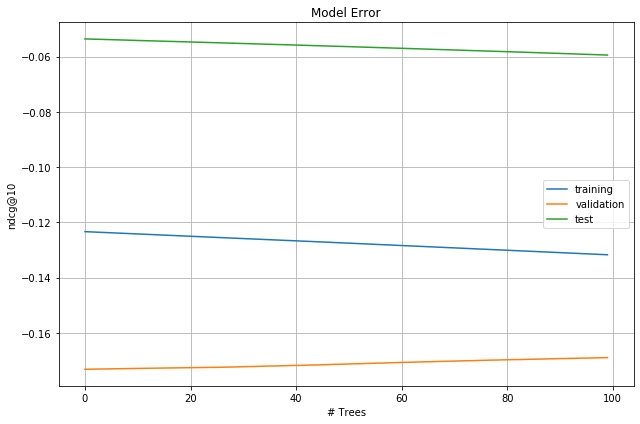

In [56]:
def evaluation(preds, train_data):
    global ds_to_queries
    bz = eval_boltzrank(ds_to_queries[len(preds)][0], preds)
    print("111preds " + str(preds))
    return METRIC_NAME, bz, True

def compute_grads(preds, train_data): 
    global ds_to_queries
    global train_id
    gain, hess = eval_boltzrank_grads(ds_to_queries[train_id][0], preds)
    gain = np.asarray(gain)
    hess = np.asarray(hess)
    #print("min " + str(np.min(gain)) + " max " + str(np.max(gain)) + " mean " + str(np.mean(gain)) + " std " + str(np.std(gain)))
    print("preds " + str(preds))
    #print("gain " + str(gain))
    #print("hess " + str(hess))
    return gain, hess

params = {
    'learning_rate': 0.1,
    'num_leaves': 16,
    'min_data_in_leaf': 5,
    'metric': ['None'],#['ndcg'],# ['None']
    #'ndcg_eval_at': 10
}    

print("training lightgbm...")
start = time.process_time()
lgbm_info = {}
lgbm_model = lightgbm.train(params, train_lgb, num_boost_round=100,
                            feval = evaluation,
                            fobj  = compute_grads,
                            valid_sets   = [train_lgb, valid_lgb, test_lgb], 
                            valid_names  = ["train", "valid", "test"],
                            evals_result = lgbm_info,
                            verbose_eval = 1)
print("training took " + str(time.process_time() - start) + " s")
print("done")

# Plot the results
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(lgbm_info['train'][METRIC_NAME], label='training')
plt.plot(lgbm_info['valid'][METRIC_NAME], label='validation')
plt.plot(lgbm_info['test'][METRIC_NAME], label='test')
plt.grid()
plt.legend()
plt.xlabel("# Trees")
plt.ylabel(METRIC_NAME)
plt.title("Model Error")

In [57]:
def check(q, k):
    indexes = set(range(0, len(q.perms)))
    indexes.remove(k)
    result = []
    for i in range(len(q.perms[k])):
        tmp = set(indexes)
        for j in tmp:
            if q.perms[k][i] != q.perms[j][i]:
                indexes.remove(j)
    for w in indexes:
        if w < k:
            result.append((w, k))
        else: 
            result.append((k,w))
    return result

def checkRepetitions():
    global queries
    same = dict()
    for q in queries.values():
        for i in range(len(q.perms)):
            r = check(q, i)
            if len(r) != 0:
                if not q.qid in same.keys():
                    same[q.qid] = set()
                for t in r:
                    same[q.qid].add(t)

    print(str(len(same.keys())) + "/" + str(len(queries.keys())) + " queries have duplicate permutations")
    for q, s in same.items():
        print("query " + str(q) + " has repeated permutations: " + str(s))
        
#checkRepetitions()            

Text(0.5, 1.0, 'ndcg@10 frequencies over 100 permutations')

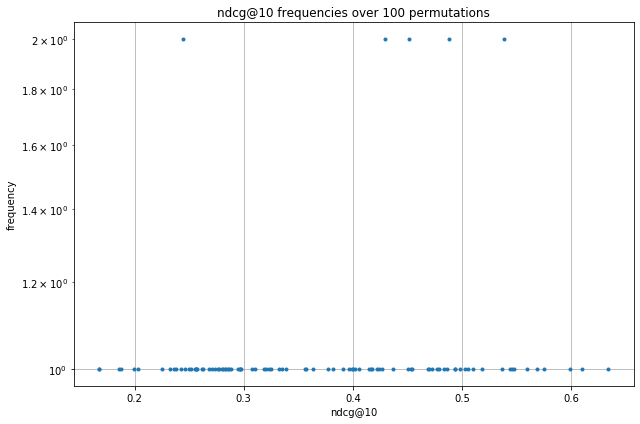

In [58]:
freq = {}
totperms = 0
for query in ds_to_queries[train_id][0].values():
    for ndcg in query.ndcgs:
        totperms += 1
        if not ndcg in freq.keys():
            freq[ndcg] = 0
        freq[ndcg] += 1

x = []
y = []
for ndcg, f in sorted(freq.items()):
    x.append(ndcg)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("ndcg@10")
plt.ylabel("frequency")
plt.yscale("log")
plt.title("ndcg@10 frequencies over " + str(totperms) + " permutations")

Text(0.5, 1.0, 'probabilities of the 100 permutations')

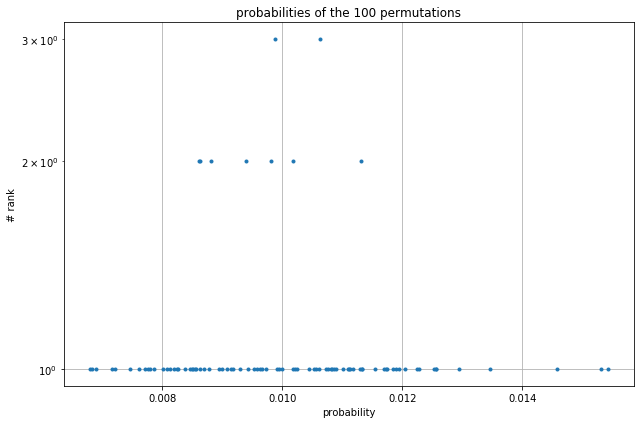

In [59]:
freq = {}
for query in ds_to_queries[train_id][0].values():
    for prob in query.probs:
        if not prob in freq.keys():
            freq[prob] = 0
        freq[prob] += 1

x = []
y = []
for prob, f in sorted(freq.items()):
    x.append(prob)
    y.append(f)
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("probability")
plt.ylabel("# rank")
plt.yscale("log")
plt.title("probabilities of the " + str(totperms) + " permutations")

In [60]:
for q in ds_to_queries[train_id][0].values():
    process_query(q, queries[1])

In [61]:
ds_to_queries[train_id][0][61]

Query 61[
ideal dcg: 25.630678014265033
4 -> [47]
2 -> [42 15  2 34 38  5 14 44 25 57]
1 -> [ 0  4  6  7  8 11 17 18 19 20 21 22 26 27 28 29 30 31 33 36 37 40 43 12
 46 49 50 51 52 53 41 55 56]
0 -> [54 39 58 10 16  3 45  9 32 23 13 48 35 24  1]]
[[12 25 39 14 16 47 13 38  1 42  2  0  4  6  7  8 11 17 18 19 20 21 22 26
 27 28 29 30 31 33 36 37 40 43 45 46 49 50 51 52 53 41 55 56 57 44 34 15
 24 58 54  5 35 23 32 48  9 10  3]] -> p: 0.010229912895844627, dcg: 0.44459674423883644
[[45 25 39 14 16 47 13 38  1 42  2  0  4  6  7  8 11 17 18 19 20 21 22 26
 27 28 29 30 31 33 36 37 40 43 12 46 49 50 51 52 53 41 55 56 57 44 34 15
 24 58 54  5 35 23 32 48  9 10  3]] -> p: 0.009435318558002097, dcg: 0.21050227367271893
[[47 25 39 14 16 45 13 38  1 42  2  0  4  6  7  8 11 17 18 19 20 21 22 26
 27 28 29 30 31 33 36 37 40 43 12 46 49 50 51 52 53 41 55 56 57 44 34 15
 24 58 54  5 35 23 32 48  9 10  3]] -> p: 0.009491581472033175, dcg: 0.26073838623545864
[[47 35 39 14 44 23 57 38  1 42 54  0  4  6  

Text(0.5, 1.0, 'ndcg@10')

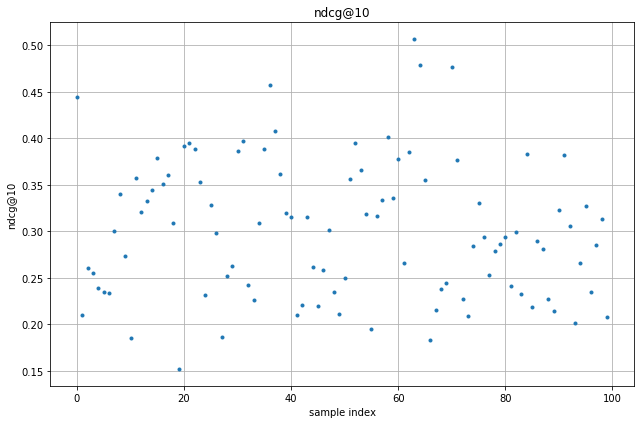

In [62]:
x = []
y = []
for i in range(len(ds_to_queries[train_id][0][61].ndcgs)):
    x.append(i)
    y.append(ds_to_queries[train_id][0][61].ndcgs[i])
    
plt.figure(figsize=(9,6), tight_layout=True)
plt.plot(x, y, '.')
plt.grid()
plt.xlabel("sample index")
plt.ylabel("ndcg@10")
plt.title("ndcg@10")